# Paillier Crypto

This script shows a simple demostration about `Paillier Crypto` algorithm on federated MNIST dataset.

## Public and Private Key

In [1]:
import os
import torch

from openfed.functional import key_gen

if not os.path.isfile('/tmp/public.key') or not os.path.isfile('/tmp/private.key'):
    public_key, private_key = key_gen()
    public_key.save('/tmp/public.key')
    private_key.save('/tmp/private.key')
    print("Generate new public and private key.")
else:
    print("Found public and private key under '/tmp'")

Found public and private key under '/tmp'


## Network and Loss

In [2]:
import torch.nn as nn

def build_network():
    network = nn.Linear(784, 10)
    loss_fn = nn.CrossEntropyLoss()
    return network, loss_fn

## Optimizer

In [3]:
from openfed.federated import is_aggregator, is_collaborator
from openfed.optim import FederatedOptimizer
import torch.optim as optim

def build_optimizer(network, role):
    sgd = optim.SGD(network.parameters(), lr=1.0 if is_aggregator(role) else 0.1)
    fed_sgd = FederatedOptimizer(sgd, role=role)
    return fed_sgd

## Topology

In [4]:
import openfed
import openfed.topo as topo

def build_topology():
    aggregator_node = topo.Node('aggregator', address=openfed.default_tcp_address)
    collaborator_node = topo.Node('collaborator', address=openfed.empty_address)
    
    topology = topo.Topology()
    topology.add_edge(collaborator_node, aggregator_node)

    return topology

## Federated Group Properties

In [5]:
def build_props(topology, role):
    fed_props = topo.analysis(topology, 'aggregator' if is_aggregator(role) else 'collaborator')
    assert len(fed_props) == 1
    fed_prop = fed_props[0]
    
    return fed_prop

## Maintainer

In [6]:
from openfed.core import Maintainer

def build_maintainer(fed_prop, state_dict, role, part_per_round):
    maintainer = Maintainer(fed_prop, state_dict)
    
    with maintainer:
        openfed.functional.device_alignment()
        if is_aggregator(role):
            openfed.functional.count_step(part_per_round)
        else:
            public_key = openfed.functional.PublicKey.load('/tmp/public.key')
            openfed.functional.paillier_package(public_key)
    return maintainer

## Dataset

In [7]:
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
from openfed.data import IIDPartitioner, PartitionerDataset

def build_dataset():
    # Dataset
    mnist = MNIST(r'/tmp/', True, ToTensor(), download=True)
    fed_mnist = PartitionerDataset(mnist, total_parts=10, partitioner=IIDPartitioner())

    # Dataloader
    dataloader = DataLoader(fed_mnist, batch_size=10, shuffle=True, num_workers=0, drop_last=False)
    
    return dataloader

## API

In [8]:
def build_API(maintainer, fed_sgd, rounds):
    private_key = openfed.functional.PrivateKey.load('/tmp/private.key')
    api = openfed.API(maintainer,
                fed_sgd,
                rounds,
                agg_func=openfed.functional.paillier_aggregation,
                agg_func_kwargs=dict(private_key=private_key),
               )
    return api

## Step

In [9]:
import random
import time

def step(mt, dataloader, network, loss_fn, fed_optim, rounds, part_per_round):
    version = 0
    outter_losses = []
    for outter in range(rounds):
        outter_loss = []
        for inner in range(part_per_round):
            mt.update_version(version)
            mt.step(upload=False)

            part_id = random.randint(0, 9)
            dataloader.dataset.set_part_id(part_id)

            network.train()
            losses = []
            tic = time.time()
            for data in dataloader:
                x, y = data
                output = network(x.view(-1, 784))
                loss = loss_fn(output, y)

                fed_optim.zero_grad()
                loss.backward()
                fed_optim.step()
                losses.append(loss.item())
            toc = time.time()
            loss = sum(losses) / len(losses)
            outter_loss.append(loss)
            duration = toc - tic

            fed_optim.round()

            mt.update_version(version + 1)
            mt.package(fed_optim)
            mt.step(download=False)
            fed_optim.clear_state_dict()
        version += 1
        outter_losses.append(sum(outter_loss) / len(outter_loss))
    torch.save(outter_losses, '/tmp/outter_losses')

## Main Function

In [10]:
def main_function(role, rounds, part_per_round):
    # Network
    network, loss_fn = build_network()
    
    if is_aggregator(role):
        print(network)
        print(loss_fn)
    
    # Optimizer
    fed_sgd = build_optimizer(network, role)
    
    if is_aggregator(role):
        print(fed_sgd)

    # Topology
    topology = build_topology()
    
    if is_aggregator(role):
        print(topology)
    
    # Federated Group Properties
    fed_prop = build_props(topology, role)
    
    print(fed_prop)
    
    # Maintainer
    maintainer = build_maintainer(fed_prop, network.state_dict(keep_vars=True), role, part_per_round)

    if is_aggregator(role):
        api = build_API(maintainer, fed_sgd, rounds)
        api.start()
    else:
        dataloader = build_dataset()
        step(maintainer, dataloader, network, loss_fn, fed_sgd, rounds, part_per_round)

## Enable colorize output

In [11]:
from openfed.utils.utils import FMT

FMT.color = True

## Run

In [12]:
from multiprocessing import Process
import openfed
rounds = 3
part_per_round = 5

aggregator_pc = Process(target=main_function, args=(openfed.federated.aggregator, rounds, part_per_round))
collaborator = Process(target=main_function, args=(openfed.federated.collaborator, rounds, part_per_round))

aggregator_pc.start()
collaborator.start()

aggregator_pc.join()
collaborator.join()

Linear(in_features=784, out_features=10, bias=True)
CrossEntropyLoss()
<OpenFed> FederatedProperties
+----------------------+--------------+
|         role         |  nick_name   |
+----------------------+--------------+
| openfed_collaborator | collaborator |
+----------------------+--------------+
<OpenFed> Address
+---------+---------------------+------------+------+
| backend |     init_method     | world_size | rank |
+---------+---------------------+------------+------+
|   gloo  | tcp://lo...ost:1994 |     2      |  1   |
+---------+---------------------+------------+------+


<OpenFed> FederatedOptimizer
SGD (
Parameter Group 0
    dampening: 0
    lr: 1.0
    momentum: 0
    nesterov: False
    weight_decay: 0
)

+--------------+--------------+------------+
|    CO\AG     | collaborator | aggregator |
+--------------+--------------+------------+
| collaborator |      .       |     ^      |
|  aggregator  |      .       |     .      |
+--------------+--------------+------------

100%|██████████| 3/3 [00:12<00:00,  4.10s/it]


## Result

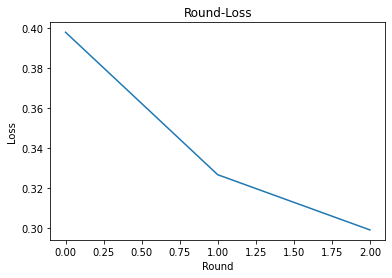

In [13]:
%matplotlib inline

import matplotlib.pyplot as plt

outter_losses = torch.load('/tmp/outter_losses')

plt.figure()
plt.plot(outter_losses)
plt.title('Round-Loss')
plt.xlabel('Round')
plt.ylabel('Loss')
plt.show()